In [1]:
!pip install spark-nlp
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.6/547.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=6290963a52025405fa1afbdb25a53e5d92f1c12560e39dfa3d597bdf0f16017f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
# Importing necessary libraries
import json
import os
import random
import string
import re
import numpy as np

import sparknlp
from sparknlp.annotator import *
from sparknlp.base import *

from pyspark.ml import Pipeline
from pyspark.ml.feature import Word2Vec
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round
from pyspark.sql.functions import lower
from pyspark.sql.functions import length

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import files

# Upload your kaggle.json API file here
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d yelp-dataset/yelp-dataset
!unzip -q yelp-dataset.zip
# Remove the unwanted files
os.remove('yelp_academic_dataset_business.json')
os.remove('yelp_academic_dataset_checkin.json')
os.remove('yelp_academic_dataset_user.json')
os.remove('yelp_academic_dataset_tip.json')

100% 4.06G/4.07G [00:45<00:00, 152MB/s]
100% 4.07G/4.07G [00:46<00:00, 94.9MB/s]


In [5]:
# Initialize Spark NLP
spark = sparknlp.start()

In [6]:
# Read the JSON file into a DataFrame
df = spark.read.json("yelp_academic_dataset_review.json")
df.show(10)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [7]:
# drop columns which are not used
df = df.drop("review_id","business_id", "date", "cool", "funny", "useful", "user_id")
df.show(10)

+-----+--------------------+
|stars|                text|
+-----+--------------------+
|  3.0|If you decide to ...|
|  5.0|I've taken a lot ...|
|  3.0|Family diner. Had...|
|  5.0|Wow!  Yummy, diff...|
|  4.0|Cute interior and...|
|  1.0|I am a long term ...|
|  5.0|Loved this tour! ...|
|  5.0|Amazingly amazing...|
|  3.0|This easter inste...|
|  3.0|Had a party of 6 ...|
+-----+--------------------+
only showing top 10 rows



In [8]:
# add a column corresponding to the length of each review
df = df.withColumn("text_length", length("text"))
df.show(10)

+-----+--------------------+-----------+
|stars|                text|text_length|
+-----+--------------------+-----------+
|  3.0|If you decide to ...|        513|
|  5.0|I've taken a lot ...|        829|
|  3.0|Family diner. Had...|        339|
|  5.0|Wow!  Yummy, diff...|        243|
|  4.0|Cute interior and...|        534|
|  1.0|I am a long term ...|        341|
|  5.0|Loved this tour! ...|        804|
|  5.0|Amazingly amazing...|        192|
|  3.0|This easter inste...|        526|
|  3.0|Had a party of 6 ...|        524|
+-----+--------------------+-----------+
only showing top 10 rows



In [9]:
# removing the reviews with the length more than 500
df = df.filter(df["text_length"] <=500)

In [10]:
# drop the column text_length
df= df.drop("text_length")

In [11]:
# count and print the number of data points
data_count = df.count()
print("number of data points: ",data_count)

number of data points:  4170954


In [12]:
# count and print the number of data points per stars
count_per_star = df.groupBy("stars").count()
count_per_star.show()

+-----+-------+
|stars|  count|
+-----+-------+
|  1.0| 522706|
|  4.0| 817556|
|  3.0| 339729|
|  2.0| 250475|
|  5.0|2240488|
+-----+-------+



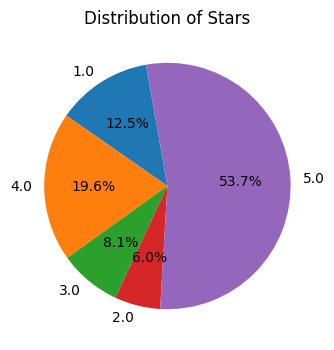

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
count_per_star_pd = count_per_star.toPandas()

# Plotting a pie chart
plt.figure(figsize=(4, 4))
plt.pie(count_per_star_pd['count'], labels=count_per_star_pd['stars'], autopct='%1.1f%%', startangle=100)
plt.title('Distribution of Stars')
plt.show()

In [13]:
# Calculate the percentage for each class
count_per_star = count_per_star.withColumn("percentage", round((col("count") / data_count) * 100, 2))
# Calculate fractions of each class(stars) for sampling
count_per_star= count_per_star.withColumn("fractions", round(1/col("percentage"),2))

# Show the DataFrame with the percentage column
count_per_star.show()

+-----+-------+----------+---------+
|stars|  count|percentage|fractions|
+-----+-------+----------+---------+
|  1.0| 522706|     12.53|     0.08|
|  4.0| 817556|      19.6|     0.05|
|  3.0| 339729|      8.15|     0.12|
|  2.0| 250475|      6.01|     0.17|
|  5.0|2240488|     53.72|     0.02|
+-----+-------+----------+---------+



In [14]:
# collect fractions in the form of a dictionary
fractions_dict = dict(count_per_star.select("stars", "fractions").rdd.collect())

In [15]:
# sample the data
df = df.sampleBy("stars", fractions= fractions_dict, seed = 123)

In [15]:
# count and print number of data points in the sampled data frame
samp_count = df.count()
print("number of data points: ",samp_count)

# count and print number of data points per each class(stars) in the sampled data frame
samp_count_per_star = df.groupBy("stars").count()
samp_count_per_star.show()

number of data points:  210470
+-----+-----+
|stars|count|
+-----+-----+
|  1.0|41619|
|  4.0|40696|
|  3.0|40878|
|  2.0|42776|
|  5.0|44501|
+-----+-----+



# Text Prepration

In [16]:
# cleaning the text of reviews by tokenizing, lemmatizing, normalizing, and removing stop word and punctuations

document_assembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

tokenizer = Tokenizer()\
  .setInputCols(["document"])\
  .setOutputCol("token")

lemmatizer = LemmatizerModel.pretrained()\
  .setInputCols(["token"])\
  .setOutputCol("lemma")

normalizer = Normalizer()\
  .setInputCols(["lemma"])\
  .setOutputCol("normalized")\
  .setLowercase(True)\
  .setCleanupPatterns(["[\\d\\s\\p{Punct}]"])

stop_words = StopWordsCleaner()\
  .pretrained("stopwords_iso","en")\
  .setInputCols(["normalized"])\
  .setOutputCol("no_stop")

finisher = Finisher()\
  .setInputCols(["no_stop"])\
  .setOutputCols("clean_text")


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
stopwords_iso download started this may take some time.
Approximate size to download 2.1 KB
[OK!]


In [17]:
# Create a pipeline for text cleaning
cleaning_pipeline = Pipeline(stages=[document_assembler, tokenizer, lemmatizer, normalizer, stop_words, finisher])

# Fit and transform the data
cleaned_data = cleaning_pipeline.fit(df).transform(df)

# Show the cleaned data
cleaned_data.select("stars", "clean_text").show(truncate=50, n=10)

+-----+--------------------------------------------------+
|stars|                                        clean_text|
+-----+--------------------------------------------------+
|  3.0|[food, good, unfortunately, consistent, ordered...|
|  5.0|[decide, need, new, doorand, green, project, bu...|
|  5.0|[good, middle, eastern, restaurant, area, food,...|
|  2.0|        [service, use, lot, service, slow, forget]|
|  3.0|[husband, oz, pepperloin, meal, happy, shrimp, ...|
|  3.0|[different, chinese, place, menu, etc, place, g...|
|  3.0|[time, service, slow, employee, dont, good, att...|
|  3.0|[definitely, line, wait, minute, pancakes, fine...|
|  1.0|[bummer, area, visit, location, didnt, receive,...|
|  1.0|         [serve, freeze, pizza, skunk, beer, nuff]|
+-----+--------------------------------------------------+
only showing top 10 rows



In [18]:
# vectorizing the clean text using Word2Vec
word2Vec = Word2Vec(vectorSize=200, minCount=5, inputCol="clean_text", outputCol="w2v_features")
assembler = VectorAssembler(inputCols=["w2v_features"], outputCol="features")

# Create the pipeline to vectorize the cleaned text
vec_pipeline = Pipeline(stages=[word2Vec, assembler])

# Fit and transform the data
df_word2Vec = vec_pipeline.fit(cleaned_data).transform(cleaned_data)

# Show the vectorize data
df_word2Vec.select("stars", "clean_text", "features").show(10)


+-----+--------------------+--------------------+
|stars|          clean_text|            features|
+-----+--------------------+--------------------+
|  3.0|[food, good, unfo...|[0.00862355353800...|
|  5.0|[decide, need, ne...|[0.03320001094075...|
|  5.0|[good, middle, ea...|[-0.0162280027844...|
|  2.0|[service, use, lo...|[0.04802385469277...|
|  3.0|[husband, oz, pep...|[-0.0892298589460...|
|  3.0|[different, chine...|[0.00736278124774...|
|  3.0|[time, service, s...|[0.06722282473411...|
|  3.0|[definitely, line...|[-0.0343721435974...|
|  1.0|[bummer, area, vi...|[0.02326935671486...|
|  1.0|[serve, freeze, p...|[-0.0095478438500...|
+-----+--------------------+--------------------+
only showing top 10 rows



In [19]:
df_word2Vec= df_word2Vec.drop("text", "w2v_features")

In [20]:
# add a labels column to data frame
# value of labels are between 0 and 4
df_word2Vec = df_word2Vec.withColumn("labels", (F.col("stars") - 1).cast("int"))

In [21]:
# split data into train and test
df_train = df_word2Vec.sampleBy("stars", fractions={1: 0.7, 2: 0.7, 3: 0.7, 4: 0.7, 5:0.7}, seed=100)
df_test = df_word2Vec.subtract(df_train)


In [24]:
df_train.show(10)

+-----+--------------------+--------------------+------+
|stars|          clean_text|            features|labels|
+-----+--------------------+--------------------+------+
|  3.0|[food, good, unfo...|[-0.0154912635733...|     2|
|  5.0|[decide, need, ne...|[0.05381454864476...|     4|
|  5.0|[good, middle, ea...|[0.06861534240570...|     4|
|  3.0|[husband, oz, pep...|[0.09948702835078...|     2|
|  3.0|[different, chine...|[0.07133084333812...|     2|
|  3.0|[time, service, s...|[-0.0902615971087...|     2|
|  3.0|[definitely, line...|[0.02295450388660...|     2|
|  1.0|[bummer, area, vi...|[0.06683098538113...|     0|
|  1.0|[serve, freeze, p...|[0.10006826526174...|     0|
|  4.0|[came, monday, lu...|[-0.0233036850113...|     3|
+-----+--------------------+--------------------+------+
only showing top 10 rows



# Multi-layered Perceptron

In [26]:
# Define the Multilayer Perceptron Classifier
mlp_classifier = MultilayerPerceptronClassifier(layers=[200, 100, 50, 5],
                                                blockSize=64,
                                                seed=1234,
                                                maxIter=150,
                                                featuresCol="features",
                                                labelCol="labels")

In [27]:
# Fit the Multilayer Perceptron model
mlp_model = mlp_classifier.fit(df_train)

# Make predictions on the test set
result_mlp = mlp_model.transform(df_test)

In [ ]:
result_mlp.select("labels","prediction","probability").show(10)

In [29]:
import pandas as pd
result_mlp_pd= result_mlp.select("labels", "prediction").toPandas()

In [30]:
from sklearn.metrics import classification_report
# Generate and print the classification report
report = classification_report(result_mlp_pd['labels'], result_mlp_pd['prediction'])
print(report)

              precision    recall  f1-score   support

           0       0.68      0.73      0.70     12664
           1       0.47      0.48      0.48     12729
           2       0.46      0.42      0.44     12243
           3       0.47      0.43      0.45     12166
           4       0.65      0.71      0.68     13336

    accuracy                           0.56     63138
   macro avg       0.55      0.55      0.55     63138
weighted avg       0.55      0.56      0.55     63138



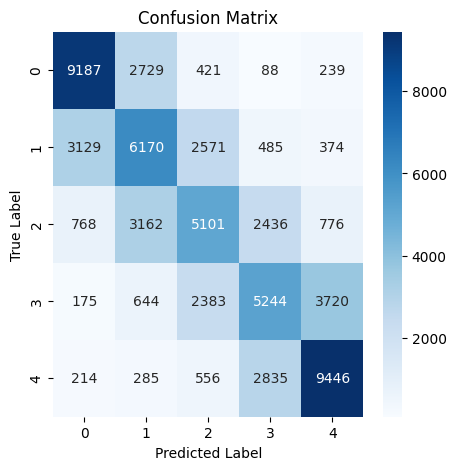

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(result_mlp_pd['labels'], result_mlp_pd['prediction'])

# Display the confusion matrix using a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Logistic Regression

In [22]:
from pyspark.ml.classification import LogisticRegression # ml model

In [28]:
# model object
lr = LogisticRegression(featuresCol='features',
                        labelCol='labels',
                        family="multinomial",
                        regParam=0.01,
                        elasticNetParam=0,
                        maxIter=100)
# make a pipeline
lr_pipeline = Pipeline(stages=[lr])

In [29]:
# train model with default parameters
lrModel = lr_pipeline.fit(df_train)

In [30]:
# get predictions for test set
result_lr = lrModel.transform(df_test)

In [26]:
result_lr.select("labels", "prediction").show(10)

+------+----------+
|labels|prediction|
+------+----------+
|     0|       4.0|
|     0|       0.0|
|     0|       0.0|
|     1|       1.0|
|     1|       0.0|
|     1|       2.0|
|     1|       1.0|
|     1|       0.0|
|     1|       2.0|
|     1|       1.0|
+------+----------+
only showing top 10 rows



In [31]:
import pandas as pd
result_lr_pd = result_lr.select("labels", "prediction").toPandas()

In [32]:
from sklearn.metrics import classification_report
# Generate and print the classification report
report = classification_report(result_lr_pd['labels'], result_lr_pd['prediction'])
print(report)

              precision    recall  f1-score   support

           0       0.68      0.73      0.70     12664
           1       0.49      0.49      0.49     12729
           2       0.47      0.43      0.45     12243
           3       0.48      0.45      0.47     12166
           4       0.66      0.71      0.68     13336

    accuracy                           0.56     63138
   macro avg       0.56      0.56      0.56     63138
weighted avg       0.56      0.56      0.56     63138



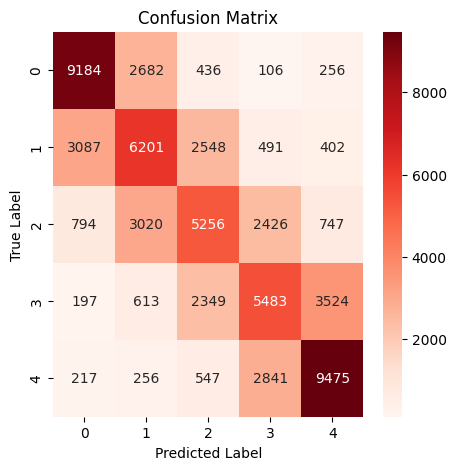

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(result_lr_pd['labels'], result_lr_pd['prediction'])

# Display the confusion matrix using a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()